,cell,area,m2_op,acc_op_cam,acc_op_veh,geometry
0,1,25980.762114,1.496370,21.999698,3261.594956,"POLYGON ((0.000 1000.000, 100.000 1000.000, 15..."
1,2,25980.762114,0.293320,20.939344,3283.642413,"POLYGON ((0.000 826.795, 100.000 826.795, 150...."
2,3,25980.762114,3.416329,25.762190,3294.544635,"POLYGON ((0.000 653.590, 100.000 653.590, 150...."
3,4,25980.762114,16.222386,47.757336,3293.653747,"POLYGON ((0.000 480.385, 100.000 480.385, 150...."
4,5,25980.762114,8.038769,51.997028,3280.187080,"POLYGON ((0.000 307.180, 100.000 307.180, 150...."


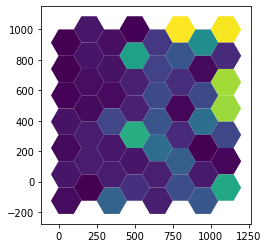

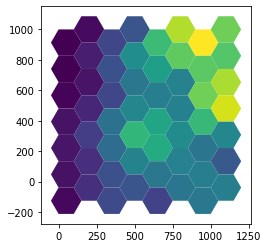

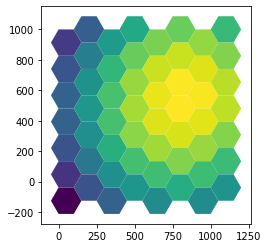

In [1]:
import pandas as pd
import geopandas as gpd
import random as rd

# Recuperamos la ciudad sintética resultante del L06
ciudad = gpd.read_file('ciudad_sintetica.shp')
ciudad.plot(column = 'm2_op')
ciudad.plot(column = 'acc_op_cam')
ciudad.plot(column = 'acc_op_veh')
ciudad.head()

## 1.1.- Base de datos de decisiones de localización (Aplicación del SII)


In [2]:
lin_con = pd.read_csv('lineas_construccion/lineas_construccion.csv', low_memory=False)

In [3]:
lin_con.head()

,Comuna,Manzana,Predial,Línea de construcción,Material estructural,Calidad construcción,Año construcción,Superficie (m2),Código de destino,Código de condición
0,1101,1,4,1,B,4,1925,631,O,NaN
1,1101,1,4,2,E,3,1925,201,O,NaN
2,1101,1,4,3,C,3,1925,91,O,NaN
3,1101,1,5,1,B,4,1925,213,O,NaN
4,1101,1,5,2,GB,2,1925,13,V,NaN


In [4]:
len(lin_con)

9503467

In [5]:
# Condiciones

comuna = 8201 # Comuna cualquiera
ano_inicio = 2018
ano_fin = 2020

bool_comuna = (lin_con['Comuna'] == comuna)
bool_ano_i = (lin_con['Año construcción'] >= ano_inicio)
bool_ano_f = (lin_con['Año construcción'] < ano_fin)
bool_uso_suelo = (lin_con['Código de destino'] == 'H') # Filtramos solo para Habitacional a modo de ejemplo

bool_total = bool_comuna & bool_ano_i & bool_ano_f & bool_uso_suelo

lin_con = lin_con.loc[bool_total]

| Calidad Construcción | Categorización |
| -------------------- | -------------- |
|         1            |       1        |
|         2            |       1        |
|         3            |       2        |
|         4            |       3        |
|         5            |       3        |

In [8]:
lin_con['cat_hogar'] = lin_con.apply(lambda row: 1 if (row['Calidad construcción'] <= 2) else 2 if (row['Calidad construcción'] <= 3) else 3 , axis = 1)

In [9]:
lin_con.head(10)

,Comuna,Manzana,Predial,Línea de construcción,Material estructural,Calidad construcción,Año construcción,Superficie (m2),Código de destino,Código de condición,cat_hogar
3349022,8201,30,6,2,C,4,2018,52,H,NaN,3
3349072,8201,31,13,2,C,3,2018,49,H,NaN,2
3349119,8201,31,32,3,C,3,2018,44,H,NaN,2
3349120,8201,31,32,4,E,3,2018,135,H,NaN,2
3355367,8201,60,4,8,A,3,2018,66,H,NaN,2
3363842,8201,114,25,1,E,4,2018,40,H,NaN,3
3367820,8201,143,249,1,B,3,2018,61,H,NaN,2
3367825,8201,143,254,1,B,3,2018,39,H,NaN,2
3367826,8201,143,255,1,B,3,2018,61,H,NaN,2
3367827,8201,143,256,1,B,3,2018,57,H,NaN,2


In [10]:
bd_localizaciones = lin_con[['Superficie (m2)', 'cat_hogar', 'Manzana']] # Ustedes deben tener el vínculo de la manzana con sus celdas...
bd_localizaciones.head()

,Superficie (m2),cat_hogar,Manzana
3349022,52,3,30
3349072,49,2,31
3349119,44,2,31
3349120,135,2,31
3355367,66,2,60


## 1.2.- Base de datos de decisiones de localización (Continuación ejemplo sintético)

In [11]:
bd_loc_sint = bd_localizaciones.sample(400)
bd_loc_sint.reset_index(inplace = True, drop = True)
bd_loc_sint.head()

,Superficie (m2),cat_hogar,Manzana
0,33,2,346
1,49,2,1303
2,53,2,6534
3,13,2,6526
4,32,2,1303


In [12]:
max_cell = ciudad['cell'].max()
bd_loc_sint['cell'] = bd_loc_sint.apply(lambda row: rd.randint(1,max_cell), axis = 1)
bd_loc_sint.head()

,Superficie (m2),cat_hogar,Manzana,cell
0,33,2,346,41
1,49,2,1303,28
2,53,2,6534,24
3,13,2,6526,19
4,32,2,1303,52


## 2.1.- Modelo Bid
### 2.1.1.- Preparación BD Bid

In [14]:
bd_bid = bd_loc_sint.copy()
bd_bid = bd_bid.join(ciudad.set_index('cell'), on = 'cell')
bd_bid.head()

,Superficie (m2),cat_hogar,Manzana,cell,area,m2_op,acc_op_cam,acc_op_veh,geometry
0,33,2,346,41,25980.762114,93.775791,260.383650,3411.932237,"POLYGON ((750.000 220.577, 850.000 220.577, 90..."
1,49,2,1303,28,25980.762114,44.434387,160.730704,3344.312002,"POLYGON ((450.000 47.372, 550.000 47.372, 600...."
2,53,2,6534,24,25980.762114,28.979621,234.496323,3420.776508,"POLYGON ((450.000 740.192, 550.000 740.192, 60..."
3,13,2,6526,19,25980.762114,19.213267,212.141137,3369.468074,"POLYGON ((300.000 307.180, 400.000 307.180, 45..."
4,32,2,1303,52,25980.762114,274.900123,492.651924,3433.000803,"POLYGON ((1050.000 740.192, 1150.000 740.192, ..."


In [15]:
bd_bid = bd_bid[['Superficie (m2)', 'cat_hogar', 'cell', 'm2_op', 'acc_op_cam', 'acc_op_veh']]
bd_bid.rename(columns={"Superficie (m2)": "N", "cat_hogar": "Cat"}, inplace = True)
bd_bid.head()

,N,Cat,cell,m2_op,acc_op_cam,acc_op_veh
0,33,2,41,93.775791,260.383650,3411.932237
1,49,2,28,44.434387,160.730704,3344.312002
2,53,2,24,28.979621,234.496323,3420.776508
3,13,2,19,19.213267,212.141137,3369.468074
4,32,2,52,274.900123,492.651924,3433.000803


### 2.1.2.- Estimación Bid

In [16]:
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.results as res
from biogeme.expressions import Beta, DefineVariable

In [17]:
database = db.Database('Modelo bid', bd_bid)
globals().update(database.variables)

In [18]:
xh = ['utilidad']
zi = ['acc_op_cam', 'acc_op_veh']
total_vars = xh+zi

In [19]:
categorias = 3 #H1, H2, H3
betas = {}
for c in range(1, categorias + 1):
    for v in total_vars:
        if c == 1:
            fixed = 1
        else:
            fixed = 0
        aux_beta = Beta(f'B_{v}_H{c}', 0, -100, 100, fixed) # B_utilidad_H1
        betas.update({f'B_{v}_H{c}': aux_beta})

In [20]:
betas

{'B_utilidad_H1': B_utilidad_H1(0),
 'B_acc_op_cam_H1': B_acc_op_cam_H1(0),
 'B_acc_op_veh_H1': B_acc_op_veh_H1(0),
 'B_utilidad_H2': B_utilidad_H2(0),
 'B_acc_op_cam_H2': B_acc_op_cam_H2(0),
 'B_acc_op_veh_H2': B_acc_op_veh_H2(0),
 'B_utilidad_H3': B_utilidad_H3(0),
 'B_acc_op_cam_H3': B_acc_op_cam_H3(0),
 'B_acc_op_veh_H3': B_acc_op_veh_H3(0)}

In [23]:
V = {}
av = {}


for c in range(1, categorias + 1):
    DP_aux = 0
    for v in xh:
        DP_aux += betas[f'B_{v}_H{c}']
    for v in zi:
        DP_aux += betas[f'B_{v}_H{c}']*database.variables[v]
    V.update({c: DP_aux})
    av.update({c: 1})

In [24]:
V

{1: (((`0` + B_utilidad_H1(0)) + (B_acc_op_cam_H1(0) * acc_op_cam)) + (B_acc_op_veh_H1(0) * acc_op_veh)),
 2: (((`0` + B_utilidad_H2(0)) + (B_acc_op_cam_H2(0) * acc_op_cam)) + (B_acc_op_veh_H2(0) * acc_op_veh)),
 3: (((`0` + B_utilidad_H3(0)) + (B_acc_op_cam_H3(0) * acc_op_cam)) + (B_acc_op_veh_H3(0) * acc_op_veh))}

In [25]:
av

{1: 1, 2: 1, 3: 1}

In [26]:
logprob = models.loglogit(V, av, Cat)
bio.WEIGHT = N
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'Ejemplo_bid'
results = biogeme.estimate()

## 2.2.- Modelo Choice
### 2.1.1.- Preparación BD Choice

In [27]:
bd_choice = bd_loc_sint.copy()
ciudad['precio_m2'] = ciudad.apply(lambda row: 10**5*rd.expovariate(row['acc_op_cam'] + row['acc_op_veh']/(ciudad['acc_op_cam'].sum()+ciudad['acc_op_veh'].sum())), axis = 1)

In [28]:
ciudad.head()

,cell,area,m2_op,acc_op_cam,acc_op_veh,geometry,precio_m2
0,1,25980.762114,1.496370,21.999698,3261.594956,"POLYGON ((0.000 1000.000, 100.000 1000.000, 15...",921.699491
1,2,25980.762114,0.293320,20.939344,3283.642413,"POLYGON ((0.000 826.795, 100.000 826.795, 150....",1437.073940
2,3,25980.762114,3.416329,25.762190,3294.544635,"POLYGON ((0.000 653.590, 100.000 653.590, 150....",2279.305638
3,4,25980.762114,16.222386,47.757336,3293.653747,"POLYGON ((0.000 480.385, 100.000 480.385, 150....",856.549814
4,5,25980.762114,8.038769,51.997028,3280.187080,"POLYGON ((0.000 307.180, 100.000 307.180, 150....",1030.467885


In [29]:
bd_choice.head()

,Superficie (m2),cat_hogar,Manzana,cell
0,33,2,346,41
1,49,2,1303,28
2,53,2,6534,24
3,13,2,6526,19
4,32,2,1303,52


In [30]:
bd_choice = bd_choice.join(ciudad.set_index('cell'), on='cell')
bd_choice.head()

,Superficie (m2),cat_hogar,Manzana,cell,area,m2_op,acc_op_cam,acc_op_veh,geometry,precio_m2
0,33,2,346,41,25980.762114,93.775791,260.383650,3411.932237,"POLYGON ((750.000 220.577, 850.000 220.577, 90...",544.327106
1,49,2,1303,28,25980.762114,44.434387,160.730704,3344.312002,"POLYGON ((450.000 47.372, 550.000 47.372, 600....",1093.440006
2,53,2,6534,24,25980.762114,28.979621,234.496323,3420.776508,"POLYGON ((450.000 740.192, 550.000 740.192, 60...",394.822693
3,13,2,6526,19,25980.762114,19.213267,212.141137,3369.468074,"POLYGON ((300.000 307.180, 400.000 307.180, 45...",5.546337
4,32,2,1303,52,25980.762114,274.900123,492.651924,3433.000803,"POLYGON ((1050.000 740.192, 1150.000 740.192, ...",54.818751


In [32]:
def aleatorio_sin_rep(n, max_cell):
    rnd = rd.randint(1, max_cell)
    while rnd == n:
        rnd = rd.randint(1, max_cell)
    return rnd

no_elecc = 2
for i in range(1, no_elecc+1):
    bd_choice[f'cell_not_{i}'] = bd_choice.apply(lambda row: aleatorio_sin_rep(row['cell'], max_cell), axis = 1)
    bd_choice = bd_choice.join(ciudad.set_index('cell'), on= f'cell_not_{i}', rsuffix= f'_not_{i}')
    bd_choice.drop([f'area_not_{i}', f'geometry_not_{i}'], axis=1, inplace = True)

bd_choice.drop(['area', 'geometry', 'Manzana'], axis=1, inplace = True)
bd_choice.rename(columns={"Superficie (m2)": "Sup", "cat_hogar": "Cat"}, inplace = True)
bd_choice['choice'] = 0
bd_choice.head()

,Sup,Cat,cell,m2_op,acc_op_cam,acc_op_veh,precio_m2,cell_not_1,m2_op_not_1,acc_op_cam_not_1,acc_op_veh_not_1,precio_m2_not_1,cell_not_2,m2_op_not_2,acc_op_cam_not_2,acc_op_veh_not_2,precio_m2_not_2,choice
0,33,2,41,93.775791,260.383650,3411.932237,544.327106,54,68.109382,270.305149,3413.324584,998.387827,54,68.109382,270.305149,3413.324584,998.387827,0
1,49,2,28,44.434387,160.730704,3344.312002,1093.440006,44,8.000228,426.358512,3444.413075,9.556292,33,113.335212,351.573131,3423.564580,285.189484,0
2,53,2,24,28.979621,234.496323,3420.776508,394.822693,32,83.417510,338.863016,3444.850556,436.863836,7,10.164248,32.499464,3219.880356,3389.709384,0
3,13,2,19,19.213267,212.141137,3369.468074,5.546337,31,71.083752,250.654813,3449.227086,136.582793,25,29.631787,272.157388,3425.538254,48.288110,0
4,32,2,52,274.900123,492.651924,3433.000803,54.818751,31,71.083752,250.654813,3449.227086,136.582793,14,1.417745,95.490087,3280.588018,109.565275,0


In [33]:
database = db.Database("Modelo Choice", bd_choice)
globals().update(database.variables)

In [37]:
xh = ['Sup']
zi = ['acc_op_cam', 'acc_op_veh']
ri = ['precio_m2']
total_vars = xh + zi + ri

In [38]:
betas = {}
for v in total_vars:
    auxBeta = Beta(f'B_{v}',0,-100,100,0)
    betas.update({f'B_{v}': auxBeta})

In [39]:
V_choice = 0
for v in total_vars:
    V_choice += betas['B_{}'.format(v)]*database.variables[v]
    
V = {0: V_choice}
av = {0:1}

V_nochoice = []
for i in range(1, no_elecc+1):
    V_nochoice_aux = 0
    for v in xh:
        V_nochoice_aux += betas['B_{}'.format(v)]*database.variables[v]
    for v in zi:
        V_nochoice_aux += betas['B_{}'.format(v)]*database.variables['{}_not_{}'.format(v,i)]
    for v in ri:
        V_nochoice_aux += betas['B_{}'.format(v)]*database.variables['{}_not_{}'.format(v,i)]
    
    V.update({i: V_nochoice_aux})
    av.update({i:1})

In [40]:
logprob = models.loglogit(V, av, choice)
bio.WEIGHT = 'Sup'
biogeme  = bio.BIOGEME(database,logprob)
biogeme.modelName = "choice"
results = biogeme.estimate()